In [1]:
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
import scipy.io as sio
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn.plotting import view_img
import math
import os
from os.path import join, exists, split
from pathlib import Path
import sys
import time
import urllib.request
import copy
import warnings
from tqdm import tqdm
from pprint import pprint
from bids.layout import BIDSLayout

In [2]:
datadir = Path('/tank/shared/2023/dist_supp_pRF/pilot_data/')
datadir_bids = Path(datadir, 'bids_data')
derivatives = 'derivatives'
datadir_fmriprep = Path(datadir, derivatives, 'fmriprep')
datadir_freesufer = Path(datadir, derivatives, 'freesurfer')
outputdir = Path(datadir, derivatives, 'pRFmapping', 'loc_24')

In [3]:
sub = '002'
ses = '01'
bg_run = 1

In [4]:
bids_layout = BIDSLayout(datadir_bids, validate=False)
fmriprep_layout = BIDSLayout(datadir_fmriprep, validate=False)

## Load background image

In [5]:
bg_image_fn = fmriprep_layout.get(subject=sub, 
                                  session=ses, 
                                  task='ping', 
                                  run=bg_run, 
                                  space='T1w',
                                  suffix="boldref",
                                  extension='nii.gz')[0]
bref = nib.load(bg_image_fn)

bmask_fn = fmriprep_layout.get(subject=sub,
                                 session=ses,
                                 task='ping',
                                 run=bg_run,
                                 space='T1w',
                                 suffix='mask',
                                 extension='nii.gz')[0]
bmask = nib.load(bmask_fn)

## Load R2


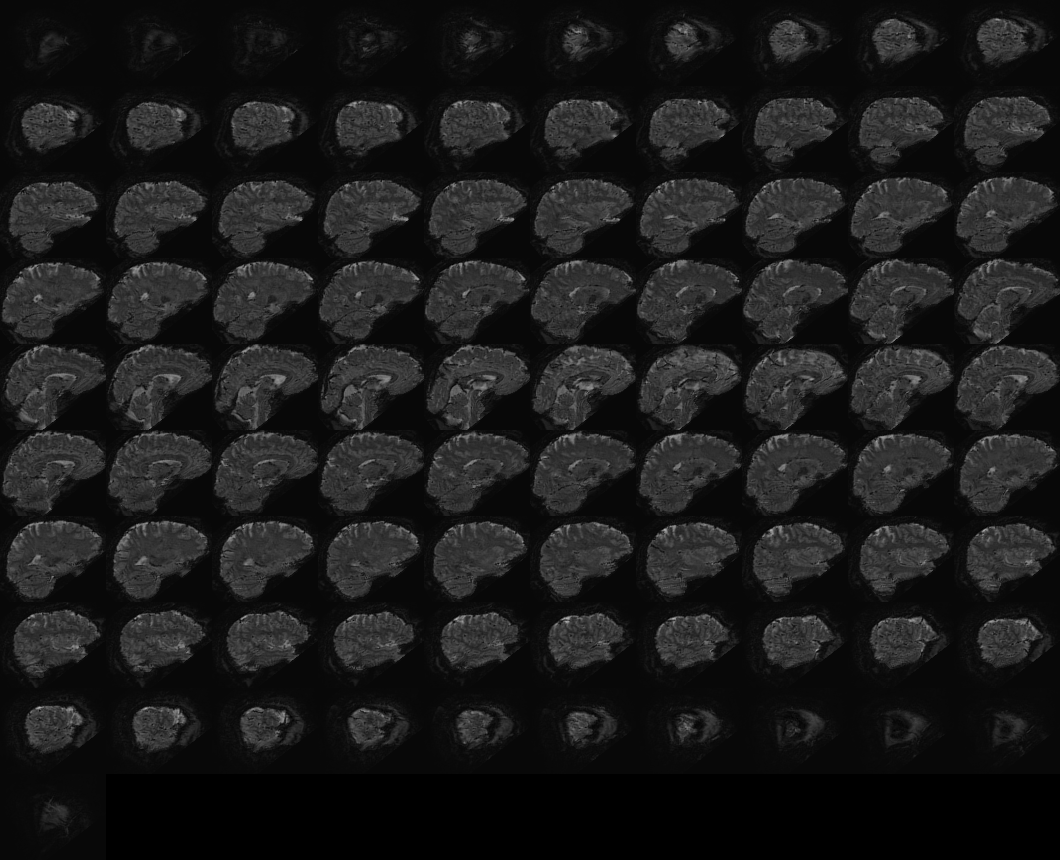
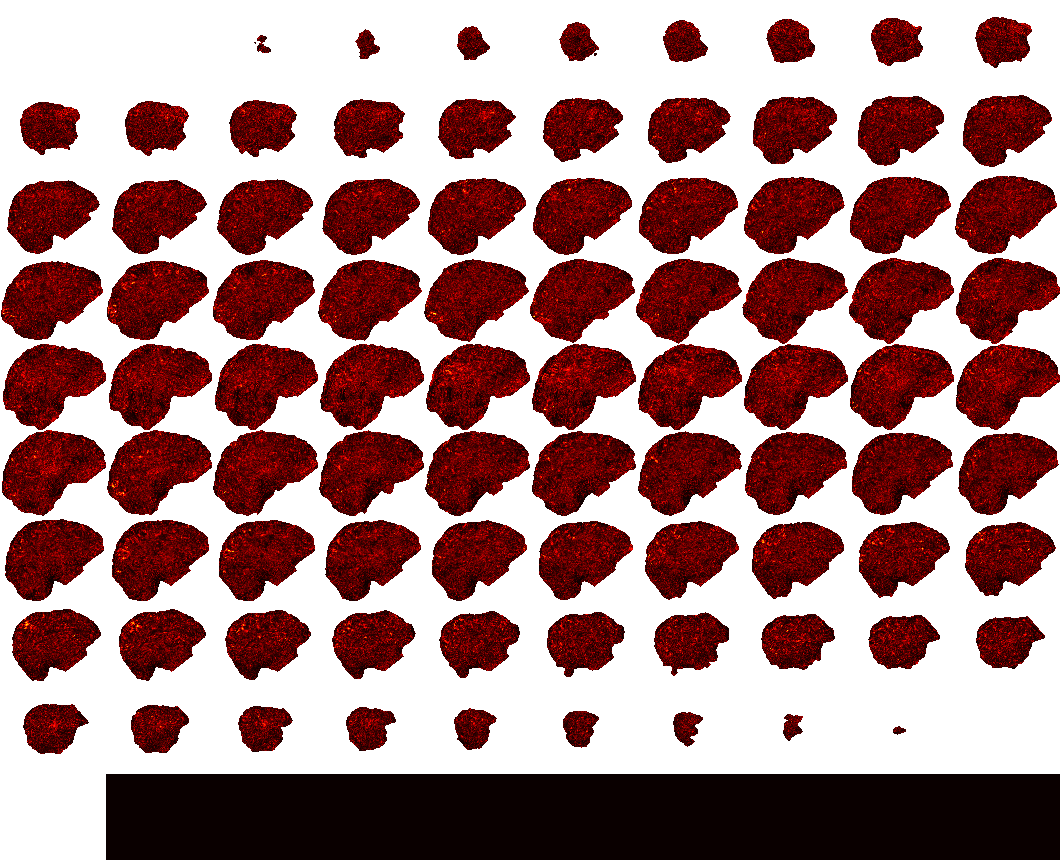

In [8]:
R2 = nib.load(Path(outputdir,'prf_rsq.nii.gz'))
R2.get_fdata()[bmask.get_fdata()<1] = np.nan
R2 = nib.Nifti1Image(R2.get_fdata(), R2.affine, R2.header)
view_img(R2,
         # threshold='80%',
         cmap='hot', 
         # vmin=0,
         symmetric_cmap=False, 
         bg_img=bg_image_fn,)


## Load retinamap

In [9]:
R2_percentile = 80

prf_rsq = nib.load(Path(outputdir,'prf_rsq.nii.gz'))
retinamap = nib.load(Path(outputdir,'prf_best_angle.nii.gz'))

# set threshold
prf_rsq_data = prf_rsq.get_fdata()
prf_rsq_data[bmask.get_fdata()<1] = np.nan
q = np.nanpercentile(prf_rsq_data, R2_percentile)
prf_rsq_data[prf_rsq_data<q] = np.nan
retinamap_data = retinamap.get_fdata()
retinamap_data[np.isnan(prf_rsq_data)] = np.nan 
retinamap_thred = nib.Nifti1Image(retinamap_data, retinamap.affine, retinamap.header)
R2_data_thred = nib.Nifti1Image(prf_rsq_data, prf_rsq.affine, prf_rsq.header)

In [10]:
print(f"The range of the thresholded R2 is from {np.nanmin(prf_rsq_data):.2f} to {np.nanmax(prf_rsq_data):.2f}")

The range of the thresholded R2 is from 0.02 to 0.12



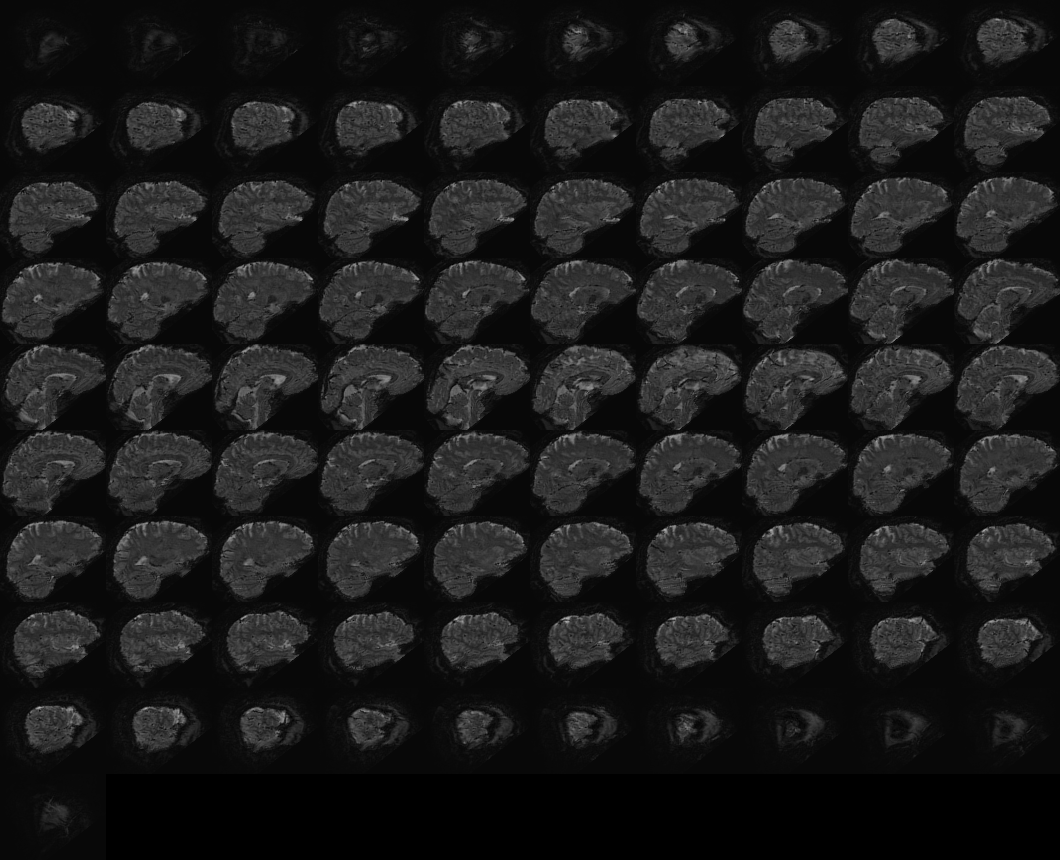
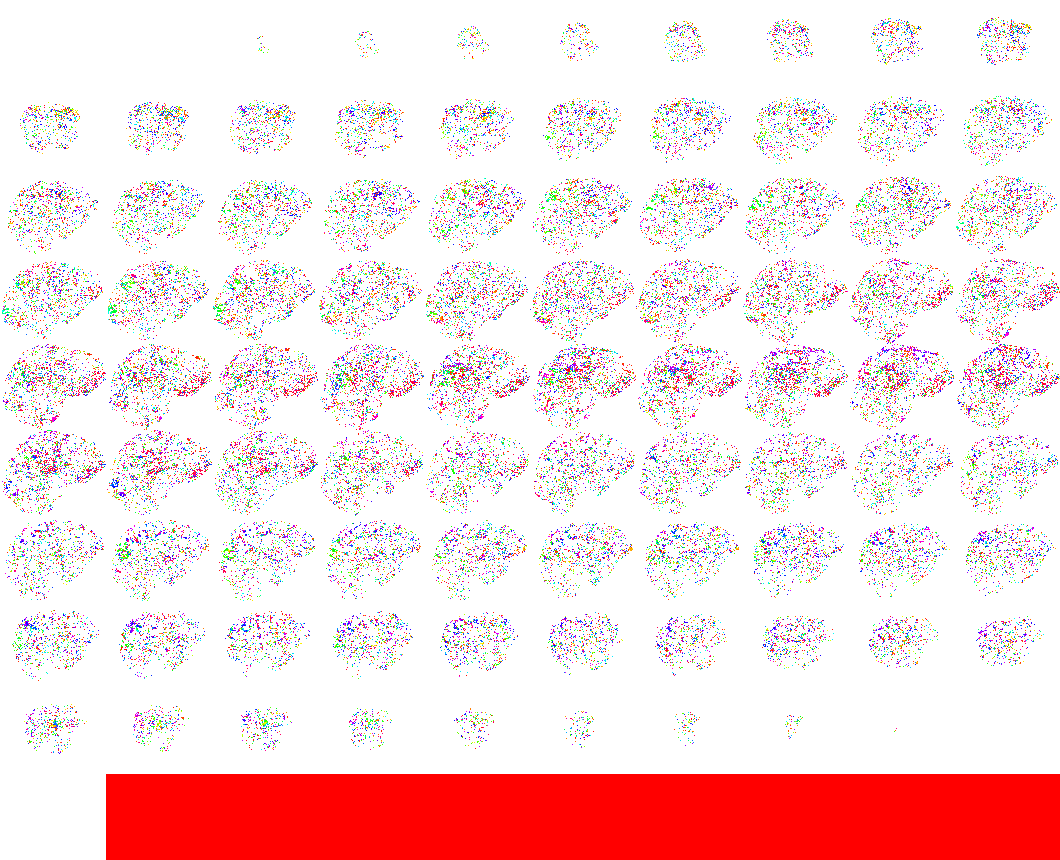

In [11]:
view_img(retinamap_thred,
         cmap='hsv', 
         symmetric_cmap=False, 
         bg_img=bg_image_fn,)